# Chapter 2: End-to-End Machine Learning Project

**Book:** Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (3rd Edition)

In [21]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

# Plot settings
%matplotlib inline
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Working with Real Data

### Data Repositories
- [OpenML](https://www.openml.org/) - data sets and tasks (*couldn't sign up, try later*)
- [Kaggle](https://kaggle.com/datases)
- [UC Irvine ML Repository](https://archive.ics.uci.edu/datasets) - datasets (e.g. Iris)
- [Amazon's AWS datasets](https://registry.opendata.aws/)
- [TensorFlow datasets](https://www.tensorflow.org/datasets)
  
### Meta portals and lists
- [DataPortals](https://dataportals.org/)
- [Wikipedia's list of ML datasets](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)
- [Quora's list](https://www.quora.com/Where-can-I-find-large-datasets-open-to-the-public)
- [Datasets subreddit](https://www.reddit.com/r/datasets/)

### Papers
- https://huggingface.co/papers/trending

## Scikit-Learn Design

**Consistency** - all objects share a consistent and simple interface

- Estimators - any object that can estimate some params based on a dataset
  - estimation is performed by `fit()`
- Transformers - estimators that can also transform dataset
  - transformation is performed by `transform()`
  - estimation + transformation - `fit_transform()`
- Predictors - estimator that can also make prediction
  - prediction is performed by `predict()`
  - measures the quality of predictions by `score()`

**Inspection** - all estimator's hyperparams are accessible via public variables, and learned params via `statistics_`

**Sensible defaults** - reasonable default values for most params

## ML Project Checklist
(full checklist in the book's Appendix A)

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data
4. Prepare the data
5. Shorlist promising models
6. Fine-Tune the system
7. Present your solution
8. Launch, monitor and maintain

## Frame the problem

- Business Objective - **predict the median housing price** in any district, and feed to another ML system to analyse possible investments
- Dataset - California Housing Prices
- Current solution - manual work and complex rules. Time consuming and with big errors
- Kind of supervision - **supervised**, multiple univariate **regression**, batch learning
- Performance measure - **root mean square error** $\text{RMSE}(\mathbf{X},h) = \sqrt{\frac{1}{m} \sum\limits_{{i=1}}^{{m}}(h(\mathbf{x}^{(i)})) - y^{(i)})^2}$ - **L2 norm**
  - typical for regression problems
  - gives higher weight to large errors
  - in case of many outliers, other option could be **mean absolute error** $\text{MAE}(\mathbf{X},h) = {\frac{1}{m} \sum\limits_{{i=1}}^{{m}}\left|h(\mathbf{x}^{(i)})) - y^{(i)}\right|}$ - **L1 norm**

## Get the Data

### Download the Data

In [4]:
from pathlib import Path
import tarfile
import urllib.request

def load_csv_from_tar(url, tar_file, data_dir, data_filepath):
    tarball_path = data_dir / tar_file
    if not tarball_path.is_file():
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as tarball:
            tarball.extractall(data_dir, filter="data")
    return pd.read_csv(data_dir / data_filepath)

In [5]:
housing_url = "https://github.com/ageron/data/raw/main/housing.tgz"
housing_tar_file = Path("housing.tar")

data_dir = Path("../../../data/raw/")
housing_data_filepath = "housing/housing.csv"

housing = load_csv_from_tar(housing_url, housing_tar_file, data_dir, housing_data_filepath)

### Look at the Data

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Fairly small dataset with **20640 instances**

`total_bedrooms` feature is missing for 207 instances

In [8]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

`ocean_proximity` is categorical with 5 different values

The rest is numerical

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


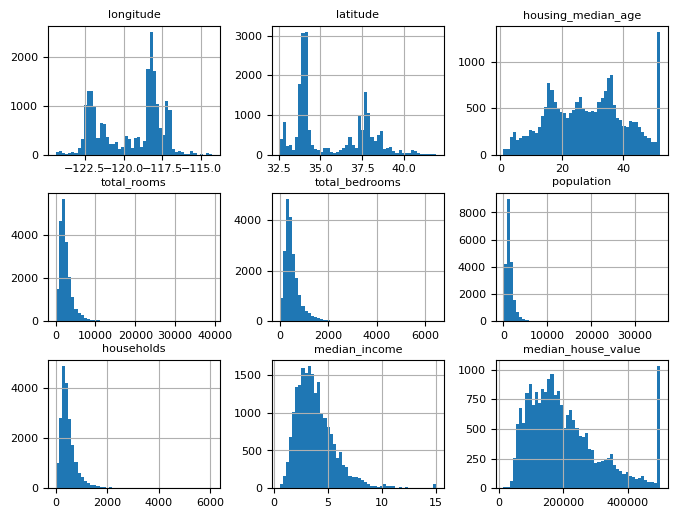

In [10]:
housing.hist(bins=50, figsize=(8, 6))
plt.show()

**Observations**
- `median_income` is expressed in 10000$ and is capped between 0.5-15000
- `median_house_value` - target, is capped 
- `housing_median_age` is capped
- attributes have different scales
- many attributes are skewed

### Create a Test Set

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Stratified sampling** - instances are devided into homogeneous subgroups called *strata*, and the right number of instances sampled from each stratum

Since `median_income` is known to be an important attribute, let's use it for stratified sampling.

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

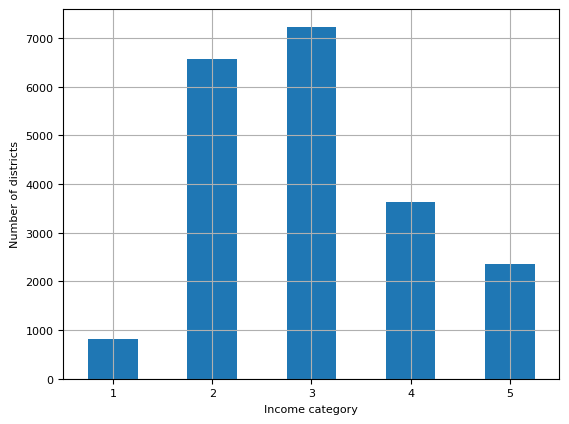

In [13]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [14]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [15]:
strat_train_set.drop(columns="income_cat", inplace=True)
strat_test_set.drop(columns="income_cat", inplace=True)

## Explore and Visualize the Data

In [16]:
housing = strat_train_set.copy()

### Visualize Geo Data

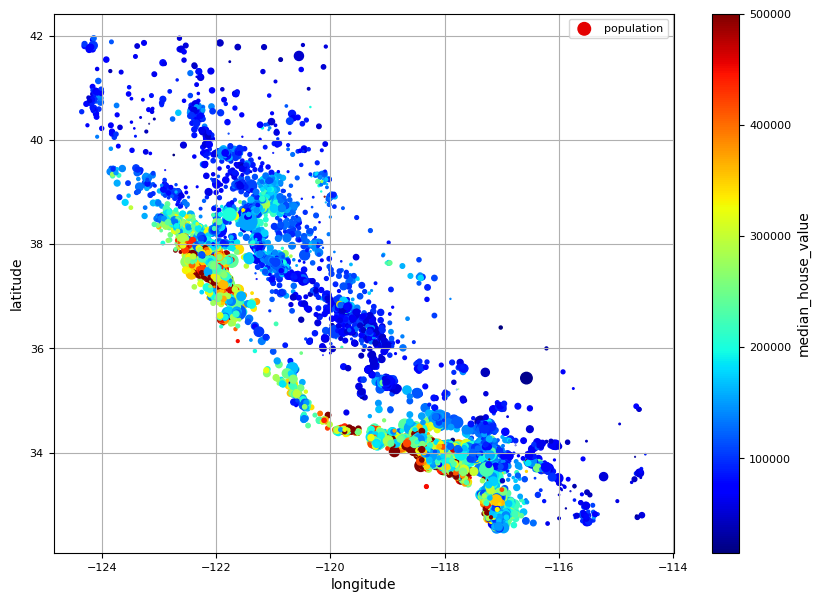

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing.population / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Prices are very much related to the location (e.g. close to the ocean) and to the population density.

Clustering algorithm can be used to detect cluster centers and introduce new features.

Ocean promixity could a feature also.

### Look for Correlations

In [33]:
corr_matrix = housing.corr(numeric_only=True)
corr_sorted = corr_matrix.median_house_value.sort_values(ascending=False)
corr_sorted

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

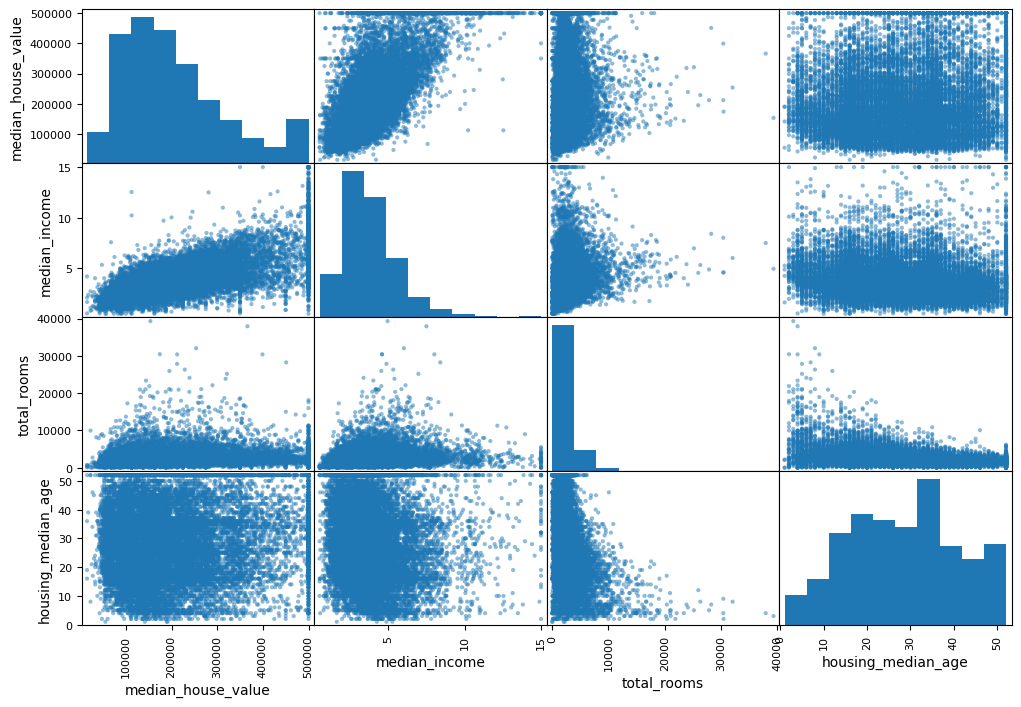

In [40]:
from pandas.plotting import scatter_matrix

top_corr_attributes = corr_sorted.index[:4]
scatter_matrix(housing[top_corr_attributes], figsize=(12, 8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

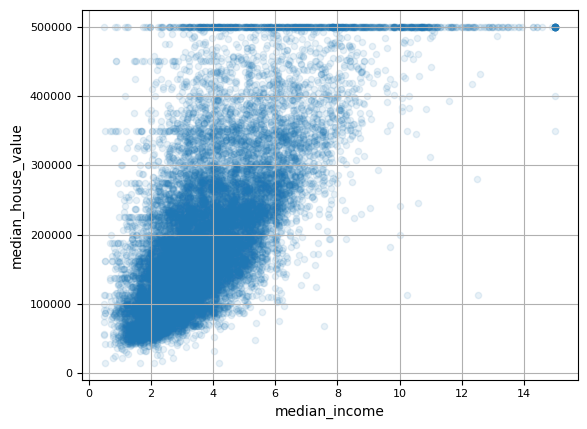

In [41]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

Correlation with `median_income` is strong, and the capped values are clearly seen.

Some strange lines around 350000 and 450000. Might be better to remove them.

### Attribute Combinations

In [42]:
housing["rooms_per_house"] = housing.total_rooms / housing.households
housing["bedrooms_ratio"] = housing.total_bedrooms / housing.total_rooms
housing["people_per_house"] = housing.population / housing.households

In [44]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

`bedrooms_ratio` and `rooms_per_house` look promising!

## Prepare the Data for Machine Learning

In [46]:
housing = strat_train_set.drop(columns=["median_house_value"])
housing_labels = strat_train_set.median_house_value.copy()

### Clean the Data

Most ML algorithms cannot work with missing features.

Options:
- remove corresponding instances
- remove corresponding attributes
- set the missing values to some value (zero, median, mean, etc.) - **imputation**

In [52]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # other options are mean, most_frequent, constant

housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


Only `total_bedrooms` had missing values, but it's safer to apply imputer to all numerical features in case production data will miss some.

In [50]:
imputer.statistics_, housing_num.median().values

(array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385]),
 array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
         408.    ,    3.5385]))

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling Text and Categorical Attributes

In [54]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [73]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [67]:
cat_encoder.categories_, cat_encoder.get_feature_names_out()

([array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
        'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
        'ocean_proximity_NEAR OCEAN'], dtype=object))

In [74]:
housing_encoded = pd.DataFrame(housing_cat_1hot, columns=cat_encoder.get_feature_names_out())
housing_encoded.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0


### Scaling and Transformation

Most ML algorithms don't perform well when numerical attributes have very different scales.

Two common ways to scaling:
- **normalization** (min-max scaling) - shift and scale to fit 0-1 interval
- **standartization** - substract the mean and devide by standart deviation. Does not fit specific range, but less affected by outliers

In [78]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_scaled = std_scaler.fit_transform(housing_num)
pd.DataFrame(housing_num_scaled, columns=housing_num.columns).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
3,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
4,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365


Most ML algorithms don't like if features's distribution has a lot of far-from-mean values.

Common ways to make distribution more simmetrical:
- replace value with its square root
- replace value with its logarithm
- bucketize the feature - chop distribution into roughly equal-sized buckets, replacing value with the bucket index
- bucketize and encode buckets as categories (if feature has >1 clear peaks - multimodal distribution)
- add separate features for each of the modes (peakes) with similarity between value and the mode

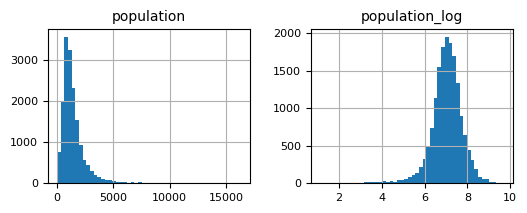

In [86]:
feature_and_log = housing[["population"]].copy()
feature_and_log["population_log"] = np.log(feature_and_log.population)
feature_and_log.hist(bins=50, figsize=(6, 2))
plt.show()

In [103]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

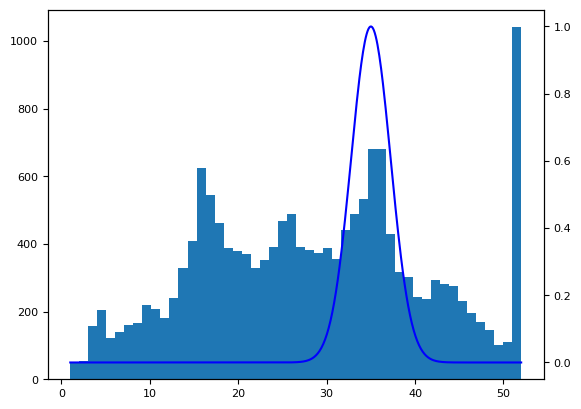

In [106]:
# Visualize
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)

fig, ax1 = plt.subplots()

ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
ax2.plot(ages, rbf1, color="blue", label="gamma = 0.10")
plt.show()

If target values need to be transformed, predictions would need to be transformed back.

`inverse_transform` or `TransformedTargetRegressor` could be used for that.

### Custom Transformers

For simple transformation without training, just define a function

In [109]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [113]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

For transformer to be trainable, custom class is required

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        pass

    def fit(self, X, y=None, sample_weight=None):
        X = check_array(X)
        # self.n_features_in = ...

        # fitting
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)

        # transform
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

        return X
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [150]:
cluster_simil = ClusterSimilarity(n_clusters=7, gamma=0.7, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.  , 0.93, 0.  , 0.  , 0.24, 0.  , 0.16],
       [0.95, 0.  , 0.12, 0.  , 0.  , 0.24, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.61, 0.  , 0.32]])

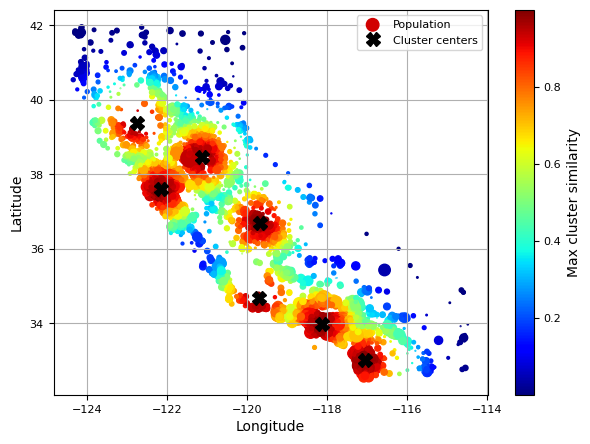

In [149]:
# Visualisation
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(7, 5))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=10,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Transformation Pipeline

In [153]:
from sklearn.pipeline import Pipeline

num_pipeline=Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standartize", StandardScaler())
])
num_pipeline

,steps,"[('impute', ...), ('standartize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [154]:
from sklearn.pipeline import make_pipeline

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)
cat_pipeline

,steps,"[('simpleimputer', ...), ('onehotencoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [160]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

# or
# preprocessing = make_column_transformer(
#     (num_pipeline, make_column_selector(dtype_include=np.number)),
#     (cat_pipeline, make_column_selector(dtype_include=object))
# )

preprocessing

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [164]:
housing_prepared = preprocessing.fit_transform(housing)
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

**Final Pipeline**

- impute missing numerical values with the median
- impute missing categorical values with most frequent category
- one-hot encode categorical features
- add a few ratio features
- add a few cluster similarity features
- replace features with a long tail with their logarithm
- standartize all numerical features

In [182]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=7, gamma=0.7, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [183]:
preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

preprocessing

,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [184]:
housing_prepared = preprocessing.fit_transform(housing)
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

## Select and Train a Model

## Fine-Tune Your Model

## Launch, Monitor, and Maintain

---
## Exercises

1. 
2. 
3. 